In [77]:
import pandas as pd
import numpy as np 
import seaborn as sn 
import matplotlib.pyplot as plt
from collections import Counter
plt.style.use("dark_background")
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, confusion_matrix, f1_score, accuracy_score, recall_score, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize, normalize

from utils import DataLoader, DataProcesser, label_plot, TimeKeeper

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
label_dic = {1: 'Still', 2: 'Walking', 3: 'Run', 4: 'Bike', 5: 'Car', 6: 'Bus', 7: 'Train', 8: 'Subway'}

# Data

## Train-Test

In [3]:
df = pd.read_csv("data/mid_res/data_ft_v1.csv").fillna(0)
col_drop_x = ['time', 'label']

In [6]:
# df['speed_log'] = df.apply(lambda x: np.log(x['speed'] + 1), axis = 1) # 运行一遍
# df['acc_wd_std'] = df[['label', 'acc']].rolling(10).std()['acc']
# df['speed_wd_std'] = df[['label', 'speed']].rolling(10).std()['speed']

In [9]:
col_drop = ['latitude',
 'longitude',
 'altitude',
 'time_dlt',
 'valid_dlt',
 'east',
 'north',
 'east_dlt',
 'north_dlt',
 'east_speed',
 'north_speed',
 'cells_ctype_mode',
 'speed_dif',
 'speed_dlt',
 'speed' # 使用 speed_log
 ]

In [10]:
list(df.drop(col_drop, axis = 1))

['time',
 'label',
 'accuracy',
 'num_gps',
 'num_wifi',
 'num_cells',
 'acc',
 'wifi_rssi_mode',
 'wifi_rssi_mean',
 'wifi_rssi_min',
 'wifi_rssi_max',
 'wifi_rssi_std',
 'wifi_freq_5ratio',
 'cells_isRegistered_mean',
 'cells_asuLevel_mean',
 'cells_dbm_mean',
 'cells_level_mean',
 'cells_asuLevel_min',
 'cells_dbm_min',
 'cells_level_min',
 'cells_asuLevel_max',
 'cells_dbm_max',
 'cells_level_max',
 'cells_asuLevel_std',
 'cells_dbm_std',
 'gps_snr_mean',
 'gps_snr_min',
 'gps_snr_max',
 'gps_snr_std',
 'speed_log',
 'acc_wd_std',
 'speed_wd_std']

In [11]:
test_ratio = 0.2
X = df.drop(col_drop_x + col_drop, axis = 1).fillna(0)

In [12]:
# sequence
# len_train = int(X.shape[0] * train_ratio)
# len_test = X.shape[0] - len_train
# X_train, X_test, y_train, y_test = X.iloc[:len_train,:], X.iloc[-len_test:,:], df['label'][:len_train], df['label'][-len_test:]
# random split
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size = test_ratio)

## Validate

In [13]:
# val = DataLoader.SHLDataLoader('data/validate/')
# val.load_all()
# dp_val = DataProcesser.DataProcesser(val)
# dp_val.process_pipe()

# val['speed_log'] = val.apply(lambda x: np.log(x['speed'] + 1), axis = 1)
# val['acc_wd_std'] = val[['label', 'acc']].rolling(10).std()['acc']

In [151]:
# save
# file = open('data/mid_res/val_ft.pickle', 'wb')
# pickle.dump(val, file)
# file.close()
# load
with open('data/mid_res/val_ft.pickle', 'rb') as file:
    val = pickle.load(file)
val.df['speed_wd_std'] = val.df[['label', 'speed']].rolling(10).std()['speed']
X_val = val.df.drop(col_drop_x + col_drop, axis = 1).fillna(0)
y_val = val.df['label']

In [18]:
# list(val.df)

---
# Model

## Random Forest

In [19]:
rf = RandomForestClassifier(n_estimators = 20, random_state = 0, max_depth = 8)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test) # label predict
pred_prob_rf = rf.predict_proba(X_test) # prob predict

## LightGBM

In [88]:
# import xgboost as xgb # 太慢
import lightgbm as lgb

In [93]:
train_data = lgb.Dataset(X_train, label = y_train - 1)
test_data = lgb.Dataset(X_test, label = y_test - 1)
params={
    'learning_rate':0.1,
    'lambda_l1':0.1,
    'lambda_l2':0.2,
    'max_depth':6,
    'objective':'multiclass',
    'num_class':8,  
}
model_lgb = lgb.train(params, train_data, valid_sets = [test_data])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4493
[LightGBM] [Info] Number of data points in the train set: 784421, number of used features: 30
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -2.081408
[LightGBM] [Info] Start training from score -2.076484
[LightGBM] [Info] Start training from score -3.143184
[LightGBM] [Info] Start training from score -2.123376
[LightGBM] [Info] Start training from

In [99]:
pred_prob_lgb = model_lgb.predict(X_test)

In [160]:
roc_auc_score(label_binarize(y_test - 1, classes= list(range(8))), pred_prob_lgb, average='micro')

0.9964864617017849

In [139]:
pred_lgb = pred_prob_lgb.argmax(axis = 1) + 1
conf = confusion_matrix(y_test , pred_lgb)
conf

array([[23169,   370,     6,   121,    49,   111,   143,   472],
       [  266, 22552,   267,   392,    39,   105,   261,   541],
       [    6,   393,  7584,   415,     5,    26,     1,     2],
       [  155,   670,   282, 21822,   471,   122,    31,    12],
       [   67,    87,    20,  1145, 30133,   305,   173,    24],
       [  255,   117,    17,   401,  1853, 25515,   145,    36],
       [  209,    35,     2,   120,  1341,   496, 28846,    97],
       [  169,    62,     0,    20,   408,   206,   179, 22762]])

<AxesSubplot:>

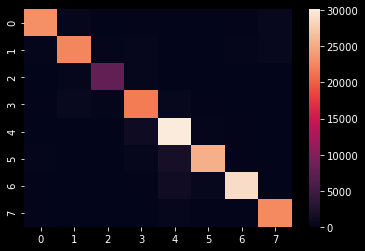

In [140]:
sn.heatmap(conf)

In [141]:
print(classification_report(y_test, pred_lgb, target_names = list(label_dic.values())))

              precision    recall  f1-score   support

       Still       0.95      0.95      0.95     24441
     Walking       0.93      0.92      0.93     24423
         Run       0.93      0.90      0.91      8432
        Bike       0.89      0.93      0.91     23565
         Car       0.88      0.94      0.91     31954
         Bus       0.95      0.90      0.92     28339
       Train       0.97      0.93      0.95     31146
      Subway       0.95      0.96      0.95     23806

    accuracy                           0.93    196106
   macro avg       0.93      0.93      0.93    196106
weighted avg       0.93      0.93      0.93    196106



In [142]:
pred_prob_lgb_val = model_lgb.predict(X_val)
pred_lgb_val = pred_prob_lgb_val.argmax(axis = 1) + 1
conf = confusion_matrix(val.df['label'] , pred_lgb_val)

In [143]:
conf

array([[14998,  1331,     1,   141,     4,   197,  3138, 10026],
       [ 3905, 14952,   258,  1285,   125,  2018,  1357,  2249],
       [    5,   854,   218,  1672,     0,     2,    15,     8],
       [  397,  1297,  1100,  7757,    27,     5,    27,  1421],
       [  366,   369,    15,  1360,  8440,  4244,  3376,  2303],
       [ 1255,   371,     2,    94,   106,  4599,  1807,   944],
       [ 1371,  1467,     0,   112,  2812,   482, 11111,  4453],
       [   11,   129,     0,     7,    77,    44,  1084, 20357]])

<AxesSubplot:>

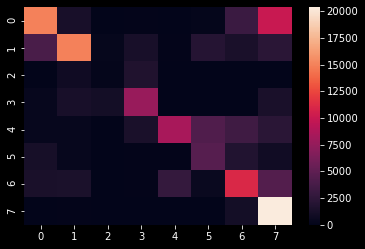

In [144]:
sn.heatmap(conf)

In [136]:
print(classification_report(y_val, pred_lgb_val, target_names = list(label_dic.values())))

              precision    recall  f1-score   support

       Still       0.67      0.50      0.58     29836
     Walking       0.72      0.57      0.64     26149
         Run       0.14      0.08      0.10      2774
        Bike       0.62      0.64      0.63     12031
         Car       0.73      0.41      0.53     20473
         Bus       0.40      0.50      0.44      9178
       Train       0.51      0.51      0.51     21808
      Subway       0.49      0.94      0.64     21709

    accuracy                           0.57    143958
   macro avg       0.53      0.52      0.51    143958
weighted avg       0.60      0.57      0.57    143958



In [163]:
roc_auc_score(label_binarize(y_val - 1, classes = list(range(8))), pred_prob_lgb_val, average='micro')

0.8852316487979953

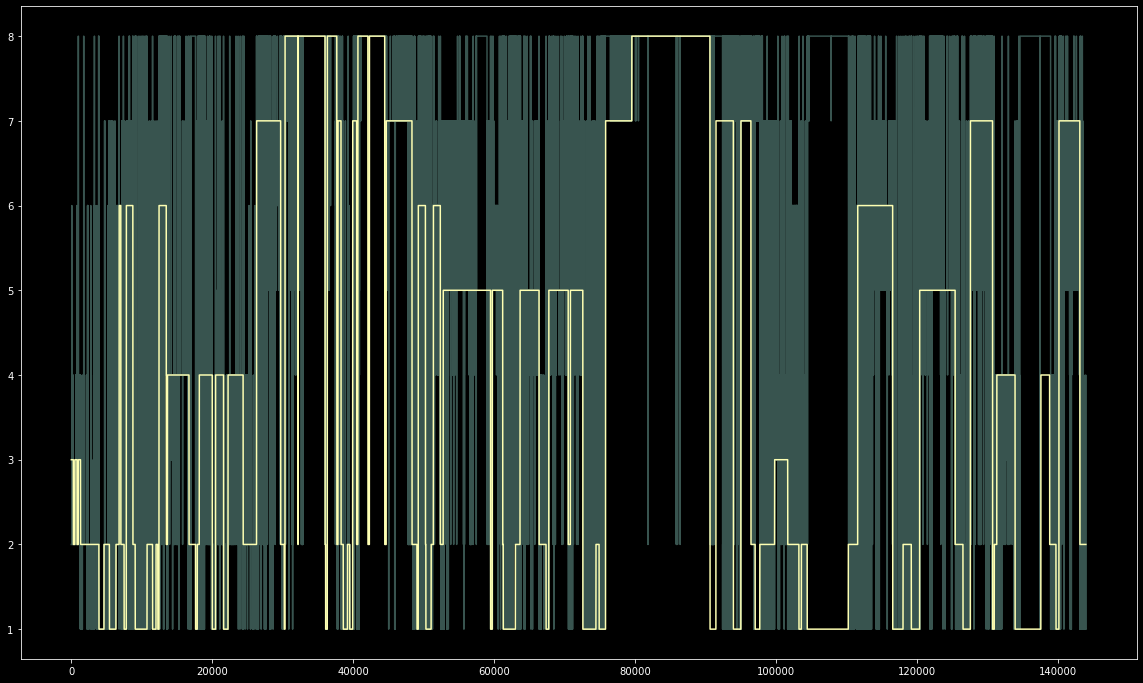

In [186]:
plt.figure(figsize = [20, 12])
plt.plot(pred_lgb_val, alpha = 0.4)
plt.plot(y_val)

## Post-Process: Mode

In [177]:
pred_df_lgb = eval_df_top2(y_val, pred_prob_lgb_val, pred_lgb_val)

Start selecting top2
Time used for select top2 in groups: 40.96
Time used for get hit columns: 3.44
Top 1 precision: 0.5726114561191459
Top 2 precesion: 0.7288167382153128


In [301]:
pred_df_lgb = pd.DataFrame(pred_prob_lgb_val, columns = list(label_dic.values()))
pred_df_lgb['pred'] = pred_lgb_val
pred_df_lgb['label'] = y_val

In [448]:
label_dic

{1: 'Still',
 2: 'Walking',
 3: 'Run',
 4: 'Bike',
 5: 'Car',
 6: 'Bus',
 7: 'Train',
 8: 'Subway'}

In [504]:
pred_lgb_val_roll = pd.Series(pred_lgb_val).rolling(180, center = True).agg(lambda x: Counter(x).most_common()[0][0]).fillna(method = 'bfill').fillna(method = 'ffill')
pred_df_lgb['pred_roll'] = pred_lgb_val_roll.astype(int)

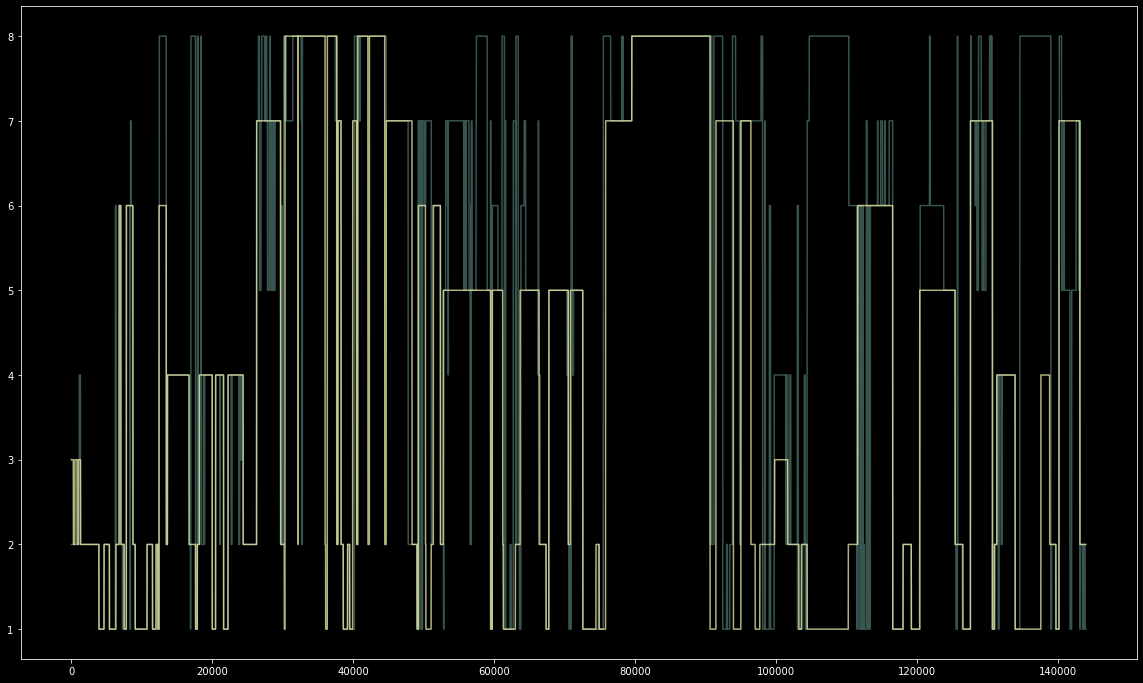

In [505]:
plt.figure(figsize = [20, 12])
plt.plot(pred_lgb_val_roll, alpha = 0.4)
plt.plot(y_val, alpha = 0.7)

              precision    recall  f1-score   support

       Still       0.69      0.54      0.61     29836
     Walking       0.82      0.64      0.72     26149
         Run       0.00      0.00      0.00      2774
        Bike       0.75      0.79      0.77     12031
         Car       0.74      0.46      0.56     20473
         Bus       0.42      0.54      0.48      9178
       Train       0.53      0.54      0.54     21808
      Subway       0.50      0.93      0.65     21709

    accuracy                           0.62    143958
   macro avg       0.56      0.56      0.54    143958
weighted avg       0.64      0.62      0.61    143958

[[16167   615     0    10     0    90  2823 10131]
 [ 3727 16642     0   561     0  1837   987  2395]
 [    0   783     0  1991     0     0     0     0]
 [  196   767   247  9534     0     0     0  1287]
 [  424   201     0   554  9355  4675  3480  1784]
 [ 1384   145     0     0     0  5001  1660   988]
 [ 1522  1096     0     0  3322   167 11772

<AxesSubplot:>

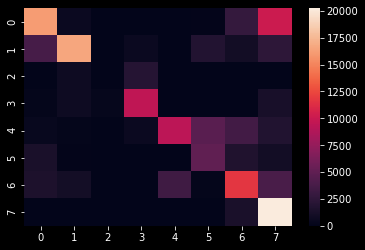

In [507]:
print(classification_report(y_val, pred_lgb_val_roll, target_names = list(label_dic.values())))
conf = confusion_matrix(y_val, pred_lgb_val_roll)
print(conf)
sn.heatmap(conf)

## Post-Process: HMM

In [217]:
from hmmlearn import hmm

In [428]:
states = list(label_dic.values())
n_states = len(states)
observations = pred_lgb_val_roll - 1
# start_probability = np.zeros(8, dtype = int)
# start_probability.put(int(pred_lgb_val_roll[0]) - 1, np.ones(8))
# start_probability = start_probability.tolist()
start_probability = pred_prob_lgb_val[:10,:].mean(axis = 0).tolist()
conf = confusion_matrix(y_val, pred_lgb_val_roll)
emission_probability = normalize(conf, axis = 1, norm = 'l1')


In [439]:
transition_probability = np.array([
  [0.80, 0.06, 0.04, 0.02, 0.02, 0.02, 0.02, 0.02],
  [0.04, 0.80, 0.06, 0.02, 0.02, 0.02, 0.02, 0.02],
  [0.01, 0.24, 0.70, 0.01, 0.01, 0.01, 0.01, 0.01],
  [0.01, 0.08, 0.06, 0.80, 0.02, 0.01, 0.01, 0.01],
  [0.02, 0.02, 0.02, 0.01, 0.90, 0.01, 0.01, 0.01],
  [0.02, 0.02, 0.02, 0.01, 0.01, 0.90, 0.01, 0.01],
  [0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.90, 0.01],
  [0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.90]
])

label_x = df['label']
label_y = df['label'].shift(1).fillna(method = 'bfill').astype(int)
t = np.zeros([8, 8])
for i in range(len(label_x)):
    t[label_x[i]-1, label_y[i]-1] += 1
transition_probability = normalize(t, axis = 1, norm = 'l1')

In [442]:
model = hmm.MultinomialHMM(n_components = n_states, n_iter = 20, tol = 0.001)
model.startprob_ = start_probability
model.transmat_ = transition_probability
model.emissionprob_ = emission_probability

In [444]:
seen = np.array(observations, dtype = int).reshape(1, -1).T
logprob, pred_hmm = model.decode(seen, algorithm="viterbi")
pred_hmm = pred_hmm + 1

In [445]:
print(classification_report(y_val, pred_hmm))

              precision    recall  f1-score   support

           1       0.69      0.54      0.60     29836
           2       0.78      0.63      0.70     26149
           3       0.22      0.02      0.04      2774
           4       0.73      0.78      0.75     12031
           5       0.73      0.44      0.55     20473
           6       0.41      0.54      0.47      9178
           7       0.53      0.53      0.53     21808
           8       0.50      0.93      0.65     21709

    accuracy                           0.61    143958
   macro avg       0.57      0.55      0.54    143958
weighted avg       0.64      0.61      0.60    143958



In [449]:
# plt.plot(pred_hmm)
# plt.plot(y_val)

In [521]:
help(seqlearn)

Help on package seqlearn:

NAME
    seqlearn

PACKAGE CONTENTS
    _decode (package)
    _utils (package)
    _version
    base
    datasets
    evaluation
    hmm
    perceptron

VERSION
    0.2

FILE
    /opt/anaconda3/lib/python3.8/site-packages/seqlearn/__init__.py




In [513]:
seqlearn.hmm.MultinomialHMM(decode = 'viterbi')

AttributeError: module 'seqlearn' has no attribute 'hmm'

## Post-Process: Rule

In [450]:
from itertools import groupby

In [486]:
def get_group_conscount(sr):
    groups = groupby(sr.values.tolist())
    grouped_elements = [list(group) for key, group in groups]
    dur_df = pd.DataFrame({"label": [t[0] for t in grouped_elements],
                        "duration": [len(t) for t in grouped_elements]})
    return dur_df

In [509]:
dur_df = get_group_conscount(df['label'])
dur_df = get_group_conscount(pred_df_lgb['pred_roll'])
dur_df = get_group_conscount(y_val)

<AxesSubplot:xlabel='label', ylabel='duration'>

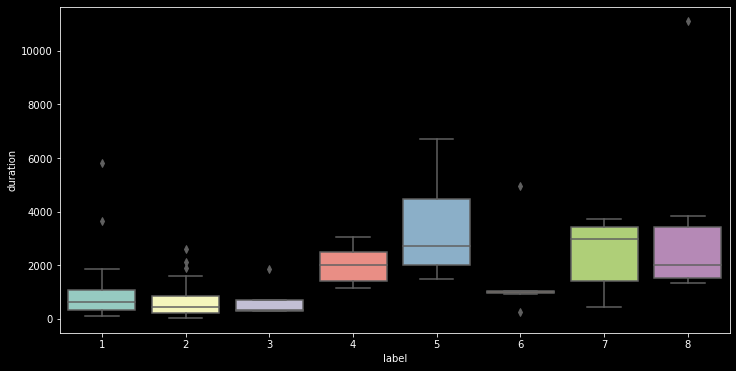

In [510]:
plt.figure(figsize = [12, 6])
sn.boxplot(x = dur_df['label'], y = dur_df['duration'])

In [511]:
dur_df.groupby(['label'], as_index = False).describe()['duration']

,count,mean,std,min,25%,50%,75%,max
0,31.0,962.451613,1153.768025,106.0,330.00,630.0,1057.50,5834.0
1,41.0,637.780488,585.951556,30.0,210.00,450.0,854.00,2610.0
2,4.0,693.500000,777.128689,285.0,307.50,315.0,701.00,1859.0
3,6.0,2005.166667,752.652753,1140.0,1395.00,1995.5,2482.75,3060.0
4,6.0,3412.166667,2046.457859,1484.0,2002.50,2729.5,4469.75,6720.0
5,6.0,1529.666667,1709.543994,241.0,944.75,1004.0,1031.00,4964.0
6,9.0,2423.111111,1297.927429,434.0,1425.00,2970.0,3420.00,3720.0
7,6.0,3618.166667,3774.312198,1350.0,1527.25,2004.0,3413.75,11099.0


## Transition Matrix

In [436]:
label_x = df['label']
label_y = df['label'].shift(1).fillna(method = 'bfill').astype(int)

In [438]:
t = np.zeros([8, 8])
for i in range(len(label_x)):
    t[label_x[i]-1, label_y[i]-1] += 1
normalize(t, axis = 1, norm = 'l1')

array([[9.98724459e-01, 4.90592881e-04, 6.54123842e-05, 2.28943345e-04,
        6.54123842e-05, 1.39001316e-04, 1.39001316e-04, 1.47177864e-04],
       [1.87348289e-04, 9.98688562e-01, 8.96013554e-05, 1.87348289e-04,
        8.96013554e-05, 3.42114266e-04, 1.95493866e-04, 2.19930600e-04],
       [9.46163308e-05, 2.83848992e-04, 9.99148453e-01, 1.18270413e-04,
        1.65578579e-04, 1.65578579e-04, 0.00000000e+00, 2.36540827e-05],
       [1.78871068e-04, 1.78871068e-04, 5.11060194e-05, 9.99429316e-01,
        6.81413592e-05, 1.70353398e-05, 7.66590292e-05, 0.00000000e+00],
       [5.04111661e-05, 9.45209364e-05, 3.78083746e-05, 3.78083746e-05,
        9.99779451e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.17700133e-04, 1.05900044e-04, 2.11800089e-05, 1.41200059e-05,
        0.00000000e+00, 9.99519920e-01, 2.11800089e-05, 0.00000000e+00],
       [2.04786894e-04, 1.02393447e-04, 1.27991809e-05, 2.55983617e-05,
        0.00000000e+00, 0.00000000e+00, 9.99648023e-01, 6.

In [447]:
pd.DataFrame(t)

,0,1,2,3,4,5,6,7
0,122145.0,60.0,8.0,28.0,8.0,17.0,17.0,18.0
1,23.0,122605.0,11.0,23.0,11.0,42.0,24.0,27.0
2,4.0,12.0,42240.0,5.0,7.0,7.0,0.0,1.0
3,21.0,21.0,6.0,117336.0,8.0,2.0,9.0,0.0
4,8.0,15.0,6.0,6.0,158660.0,0.0,0.0,0.0
5,45.0,15.0,3.0,2.0,0.0,141575.0,3.0,0.0
6,32.0,16.0,2.0,4.0,0.0,0.0,156205.0,1.0
7,23.0,22.0,0.0,0.0,0.0,0.0,2.0,119136.0


---
# Evaluation

## Test DataSet-Top1

In [21]:
pred = pred_rf
print("macro score: {}\nmicro score: {}\nweighted score: {}".format(precision_score(y_test, pred, average = "macro"),
                                                                    precision_score(y_test, pred, average = "micro"),
                                                                    precision_score(y_test, pred, average = "weighted")))
conf = confusion_matrix(y_test, pred)
conf

macro score: 0.7644688014505321
micro score: 0.7364690524512254
weighted score: 0.744723592560603


array([[20643,   844,     0,   183,   459,   571,   936,   805],
       [ 1081, 19404,   202,  1041,   227,  1051,   511,   906],
       [   22,  2282,  3824,  1811,     5,   472,     9,     7],
       [  212,  1017,   108, 18686,  1212,  2277,    29,    24],
       [  405,   142,     9,  2253, 22681,  3669,  2473,   322],
       [  892,   186,     8,  1953,  2620, 20054,  2552,    74],
       [ 1724,    41,     1,   411,  3868,  3844, 20020,  1237],
       [  524,    68,     8,   234,  1222,  1401,  1235, 19114]])

<AxesSubplot:>

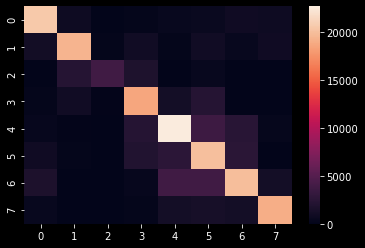

In [22]:
sn.heatmap(conf)

In [23]:
print(classification_report(y_test, pred, target_names = list(label_dic.values())))

              precision    recall  f1-score   support

       Still       0.81      0.84      0.83     24441
     Walking       0.81      0.79      0.80     24423
         Run       0.92      0.45      0.61      8432
        Bike       0.70      0.79      0.75     23565
         Car       0.70      0.71      0.71     31954
         Bus       0.60      0.71      0.65     28339
       Train       0.72      0.64      0.68     31146
      Subway       0.85      0.80      0.83     23806

    accuracy                           0.74    196106
   macro avg       0.76      0.72      0.73    196106
weighted avg       0.74      0.74      0.74    196106



## Test DataSet-Top2

In [82]:
pred_df = eval_df_top2(y_test, pred_prob_rf, pred_rf)

Time used for select top2 in groups: 58.44
Time used for get hit columns: 4.95


In [25]:
def top(x, n):
    return x.sort_values().to_list()[-n]

In [173]:
def eval_df_top2(y_test, pred_prob, pred):
    df1 = pd.DataFrame(pred_prob, columns = list(label_dic.values())) # prob
    df2 = pd.DataFrame({"label": y_test}) # label
    y_test_compare = pd.concat([df1.reset_index(drop = True), df2.reset_index(drop = True)], axis = 1, ignore_index = False)
    
    pred_df = pd.concat([df1.reset_index(drop = True), df2.reset_index(drop = True)], axis = 1, ignore_index = False)
    pred_df['pred_top1'] = pred
    timer = TimeKeeper.TimeKeeper()
    print("Start selecting top2")
    pred_df['pred_top2'] = df1.apply(lambda x: np.where(x == top(x, n = 2))[0][0] + 1, axis = 1)
    print("Time used for select top2 in groups: {}".format(timer.get_update_time()))
    pred_df['hit_top1'] = pred_df.apply(lambda x: int(x['pred_top1'] == x['label']), axis = 1)
    pred_df['hit_top2'] = pred_df.apply(lambda x: int((x['pred_top1'] == x['label']) | (x['pred_top2'] == x['label'])), axis = 1)
    print("Time used for get hit columns: {}".format(timer.get_update_time()))

    print("Top 1 precision: {}\nTop 2 precesion: {}".format(Counter(pred_df.hit_top1)[1]/np.sum(list(Counter(pred_df.hit_top1).values())),
                                                Counter(pred_df.hit_top2)[1]/np.sum(list(Counter(pred_df.hit_top2).values()))))

    return pred_df

In [30]:
# pred_df.to_csv('data/mid_res/pred_df.csv', header = True, index = False)

In [83]:
print("Top 1 precision: {}\nTop 2 precesion: {}".format(Counter(pred_df.hit_top1)[1]/np.sum(list(Counter(pred_df.hit_top1).values())),
                                                Counter(pred_df.hit_top2)[1]/np.sum(list(Counter(pred_df.hit_top2).values()))))

Top 1 precision: 0.7364690524512254
Top 2 precesion: 0.8892894659010943


In [84]:
roc_auc_score(y_test, pred_prob_rf, multi_class = 'ovo')

0.955293260987095

In [28]:
# random forest
ft_df = pd.DataFrame({"Feature": list(X), "Importance": rf.feature_importances_})
ft_df.sort_values(ascending = False, by = "Importance", inplace = True)

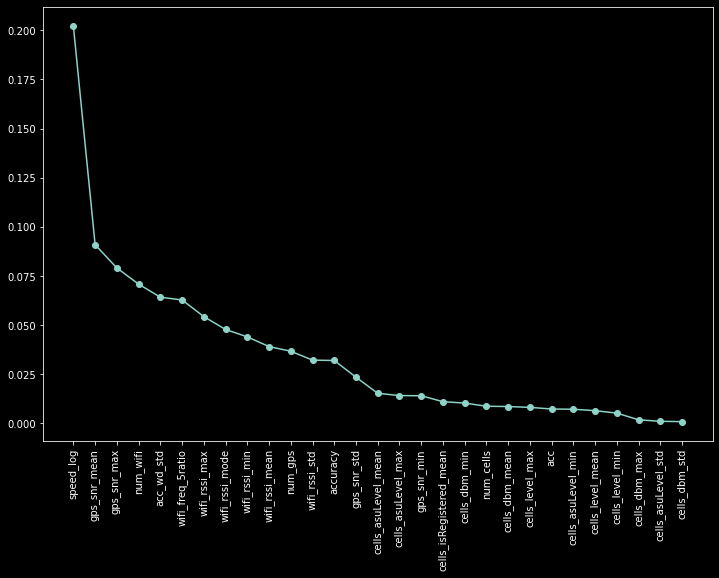

In [307]:
# feature importance
plt.figure(figsize = [12, 8])
plt.plot(ft_df['Importance'].reset_index(drop = True))
plt.scatter(range(ft_df.shape[0]), ft_df['Importance'].reset_index(drop = True))
plt.xticks(range(ft_df.shape[0]), ft_df['Feature'].reset_index(drop = True), rotation = 90);

## Validation DataSet

In [33]:
# # load
# with open('data/mid_res/val_ft.pickle', 'rb') as file:
#     val = pickle.load(file)

In [34]:

pred_rf_val = rf.predict(X_val)
pred_prob_rf_val = rf.predict_proba(X_val)

In [35]:
pred = pred_rf_val
print(classification_report(val.df['label'], pred, target_names = list(label_dic.values())))

              precision    recall  f1-score   support

       Still       0.66      0.53      0.59     29836
     Walking       0.77      0.46      0.57     26149
         Run       0.62      0.05      0.09      2774
        Bike       0.62      0.72      0.67     12031
         Car       0.53      0.44      0.48     20473
         Bus       0.27      0.55      0.36      9178
       Train       0.39      0.55      0.45     21808
      Subway       0.62      0.67      0.65     21709

    accuracy                           0.54    143958
   macro avg       0.56      0.50      0.48    143958
weighted avg       0.59      0.54      0.54    143958



In [36]:
conf = confusion_matrix(val.df['label'], pred)
conf

array([[15962,  1066,     0,   249,   435,  1384,  7365,  3375],
       [ 2705, 11900,    61,  1191,   953,  6287,  1704,  1348],
       [   14,   256,   140,   789,   361,  1178,    27,     9],
       [  306,  1421,    25,  8688,     2,   132,   130,  1327],
       [  444,   272,     0,  2478,  9030,  3367,  3790,  1092],
       [ 1779,    88,     0,   368,    73,  5052,  1089,   729],
       [ 2668,    19,     0,   286,  4919,  1019, 12017,   880],
       [  312,   340,     0,    22,  1177,   313,  4956, 14589]])

<AxesSubplot:>

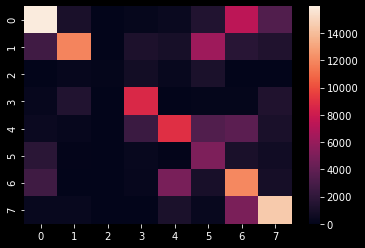

In [37]:
sn.heatmap(conf)

In [71]:
pred_df_val = eval_df_top2(val.df['label'], pred_prob_rf_val, pred_rf_val)

In [74]:
pred_df_val.to_csv('data/mid_res/pred_v1_val.csv', header = True, index = False)

In [75]:
print("Top 1 precision: {}\nTop 2 precesion: {}".format(Counter(pred_df_val.hit_top1)[1]/np.sum(list(Counter(pred_df_val.hit_top1).values())),
                                                Counter(pred_df_val.hit_top2)[1]/np.sum(list(Counter(pred_df_val.hit_top2).values()))))

Top 1 precision: 0.5375039942205365
Top 2 precesion: 0.7501354561747177
